# HAB Capstone Feature Engineering

In [1]:
#Import modules
import datetime as dt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler

import sys
sys.path.append('../src/')
from visualization.visualize import *

## Load Data, Select Basic Features

The sites_df csv contains the data for all sites within one dataframe. Here we will select the features that are expected to be the most relevant for HAB prediction and preprocess the features for machine learning.

In [2]:
sites_df = pd.read_csv('../data/interim/sites_df.csv', index_col=0, parse_dates=['Date'])
sites_df.head()

,Date,Site,Station Depth (m),Sample Depth (m),Sample Depth (category),Local Time (Eastern Time Zone),Latitude (decimal deg),Longitude (decimal deg),Wind speed (knots),Wave Height (ft),...,Nitrate + Nitrite (mg N/L),Particulate Organic Carbon (mg/L),Particulate Organic Nitrogen (mg/L),Colored Dissolved Organic Material absorbance (m-1) at 400nm,Total Suspended Solids (mg/L),Volatile Suspended Solids (mg/L),Month,Phosphate (µg/L),Distance from Maumee Inlet (km),Shore Distance (euc dis)
0,2012-05-31,WE2,8.2,0.75,Surface,11:15,41.7625,-83.3286,NaN,NaN,...,0.466,0.50,0.07,NaN,21.42,2.40,12-May,NaN,13.575315,0.055212
1,2012-06-11,WE2,5.1,0.75,Surface,10:37,41.7627,-83.3291,NaN,NaN,...,0.451,0.97,0.19,NaN,9.73,2.09,12-Jun,NaN,13.552581,0.055354
2,2012-06-22,WE2,5.3,0.75,Surface,10:08,41.7633,-83.3301,NaN,NaN,...,0.337,0.35,0.07,NaN,6.39,1.31,12-Jun,NaN,13.519762,0.055851
3,2012-07-12,WE2,5.5,0.75,Surface,10:05,41.7626,-83.3295,NaN,NaN,...,0.157,2.16,0.35,NaN,11.60,4.17,12-Jul,NaN,13.518659,0.055212
4,2012-07-23,WE2,4.9,0.75,Surface,10:58,41.7579,-83.3302,NaN,NaN,...,0.010,1.45,0.25,NaN,16.33,2.83,12-Jul,NaN,13.190484,0.050466


In [3]:
sites_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 871 entries, 0 to 870
Data columns (total 37 columns):
 #   Column                                                         Non-Null Count  Dtype         
---  ------                                                         --------------  -----         
 0   Date                                                           871 non-null    datetime64[ns]
 1   Site                                                           871 non-null    object        
 2   Station Depth (m)                                              864 non-null    float64       
 3   Sample Depth (m)                                               871 non-null    float64       
 4   Sample Depth (category)                                        871 non-null    object        
 5   Local Time (Eastern Time Zone)                                 866 non-null    object        
 6   Latitude (decimal deg)                                         871 non-null    float64       
 7  

The main features of interest are date and site location, distance from shore, temperature and oxygen concentration, and nutrient profiles. In addition to absolute nutrient concentrations HAB growth can depend on the ratio of nutrients. The nitrogen to phosphorus ratio in particular is known influence algal growth, and can play a role in the dominance of different cyanobacteria species.

In [4]:
#add in N:P Mass Ratio 
sites_df['N:P Mass Ratio'] = sites_df['Nitrate + Nitrite (mg N/L)']*1000 / sites_df['Total Phosphorus (µg P/L)']

In [5]:
#select most relevant features
features = sites_df[['Date', 'Site', 'CTD Temperature (°C)', 'CTD Dissolved Oxygen (mg/L)',
                     'Particulate Microcystin (µg/L)', 'Total Phosphorus (µg P/L)', 
                     'Total Dissolved Phosphorus (µg P/L)', 'Soluble Reactive Phosphorus (µg P/L)',
                     'Ammonia (µg N/L)', 'Nitrate + Nitrite (mg N/L)', 'N:P Mass Ratio', 
                     'Distance from Maumee Inlet (km)', 'Shore Distance (euc dis)']]

In [6]:
features.head()

,Date,Site,CTD Temperature (°C),CTD Dissolved Oxygen (mg/L),Particulate Microcystin (µg/L),Total Phosphorus (µg P/L),Total Dissolved Phosphorus (µg P/L),Soluble Reactive Phosphorus (µg P/L),Ammonia (µg N/L),Nitrate + Nitrite (mg N/L),N:P Mass Ratio,Distance from Maumee Inlet (km),Shore Distance (euc dis)
0,2012-05-31,WE2,NaN,NaN,0.10,42.01,12.29,5.15,14.68,0.466,11.092597,13.575315,0.055212
1,2012-06-11,WE2,NaN,NaN,0.10,31.57,7.86,0.76,13.90,0.451,14.285714,13.552581,0.055354
2,2012-06-22,WE2,NaN,NaN,0.10,23.11,8.02,2.62,23.44,0.337,14.582432,13.519762,0.055851
3,2012-07-12,WE2,NaN,NaN,0.40,56.62,9.07,1.09,10.01,0.157,2.772872,13.518659,0.055212
4,2012-07-23,WE2,NaN,NaN,0.37,60.98,25.05,15.56,12.82,0.010,0.163988,13.190484,0.050466


## Interpolation and Time Shift Features

Due to the time lag in environmental conditions and algal response it is advisable for each observation to also contain information on the conditions at that location over the past several weeks. We will accomplish this by isolating each site / year combination, upsampling the data to daily frequency with linear interpolation, and then adding shifted features with period shifts of 1, 2, 4, and 6 weeks. 

In [7]:
site_names = ['WE2', 'WE4', 'WE6', 'WE8', 'WE12', 'WE13', 'WE14', 'WE15', 'WE16']

In [8]:
interpolated_features = pd.DataFrame()
cols = ['CTD Temperature (°C)', 'CTD Dissolved Oxygen (mg/L)',
       'Total Dissolved Phosphorus (µg P/L)','Ammonia (µg N/L)',
        'Total Phosphorus (µg P/L)', 'Soluble Reactive Phosphorus (µg P/L)',
        'Nitrate + Nitrite (mg N/L)', 'N:P Mass Ratio']
shift_dict = {'2wks':14, '4wks':28, '6wks':42}


for site_name in site_names:
    df = features[features['Site']==site_name].set_index('Date', drop=True)
    site_interpolated = pd.DataFrame()
    
    #resample daily and perform linear interpolation per site, per year
    for year in df.index.year.unique():
        temp = df.loc[df.index.year==year].resample('D').interpolate(method='linear')
        
        #for each relevant column create a new column shifted by the periods defined in shift_dict
        for col in cols:
            for key in shift_dict.keys():
                periods=shift_dict[key]
                temp[col+'_'+key] = temp[col].shift(periods=periods).copy().fillna(method='bfill')
        temp = temp.resample('W').mean()
        
        #once finished interpolating and shifting for one year, concatenate to site_interpolated df         
        site_interpolated = pd.concat([site_interpolated,temp])
        
    site_interpolated['Site'] = site_name
    
    #concatenate finished site df to final df
    interpolated_features = pd.concat([interpolated_features, site_interpolated])
    
#fill remaining null values with median
interpolated_features.fillna(interpolated_features.median(), inplace=True)

In [9]:
interpolated_features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1073 entries, 2012-06-03 to 2019-10-13
Data columns (total 36 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   CTD Temperature (°C)                       1073 non-null   float64
 1   CTD Dissolved Oxygen (mg/L)                1073 non-null   float64
 2   Particulate Microcystin (µg/L)             1073 non-null   float64
 3   Total Phosphorus (µg P/L)                  1073 non-null   float64
 4   Total Dissolved Phosphorus (µg P/L)        1073 non-null   float64
 5   Soluble Reactive Phosphorus (µg P/L)       1073 non-null   float64
 6   Ammonia (µg N/L)                           1073 non-null   float64
 7   Nitrate + Nitrite (mg N/L)                 1073 non-null   float64
 8   N:P Mass Ratio                             1073 non-null   float64
 9   Distance from Maumee Inlet (km)            1073 non-null   float64
 10  Shore 

Due to the seasonality of algal blooms we will also add in month as a categorical feature.

In [10]:
#add in Month as a feature
interpolated_features['Month'] = interpolated_features.index.month.astype('object')

In [11]:
interpolated_features.head()

,CTD Temperature (°C),CTD Dissolved Oxygen (mg/L),Particulate Microcystin (µg/L),Total Phosphorus (µg P/L),Total Dissolved Phosphorus (µg P/L),Soluble Reactive Phosphorus (µg P/L),Ammonia (µg N/L),Nitrate + Nitrite (mg N/L),N:P Mass Ratio,Distance from Maumee Inlet (km),...,Soluble Reactive Phosphorus (µg P/L)_4wks,Soluble Reactive Phosphorus (µg P/L)_6wks,Nitrate + Nitrite (mg N/L)_2wks,Nitrate + Nitrite (mg N/L)_4wks,Nitrate + Nitrite (mg N/L)_6wks,N:P Mass Ratio_2wks,N:P Mass Ratio_4wks,N:P Mass Ratio_6wks,Site,Month
Date,,,,,,,,,,,,,,,,,,,,,
2012-06-03,22.314286,7.628571,0.100000,40.586364,11.685909,4.551364,14.573636,0.463955,11.528022,13.572215,...,5.150000,5.15,0.466000,0.466000,0.466,11.092597,11.092597,11.092597,WE2,6
2012-06-10,22.314286,7.628571,0.100000,35.366364,9.470909,2.356364,14.183636,0.456455,13.124581,13.560848,...,5.150000,5.15,0.466000,0.466000,0.466,11.092597,11.092597,11.092597,WE2,6
2012-06-17,22.314286,7.628571,0.100000,29.262727,7.903636,1.267273,16.501818,0.419909,14.366637,13.543630,...,5.150000,5.15,0.464831,0.466000,0.466,11.341411,11.092597,11.092597,WE2,6
2012-06-24,22.314286,7.628571,0.106429,24.926773,8.021721,2.345656,21.913253,0.347948,14.290835,13.524000,...,5.150000,5.15,0.456455,0.466000,0.466,13.124581,11.092597,11.092597,WE2,6
2012-07-01,22.314286,7.628571,0.190000,33.163000,8.335000,2.161000,19.411000,0.283000,11.039564,13.519431,...,4.807922,5.15,0.419909,0.464831,0.466,14.366637,11.341411,11.092597,WE2,7


We can use ECDF plots to make sure the interpolations did not drastically affect the data distributions for key features.

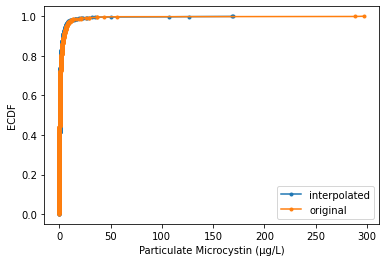

In [12]:
comp_ecdf(interpolated_features, sites_df, 'Particulate Microcystin (µg/L)', 
          name1='interpolated', name2='original')

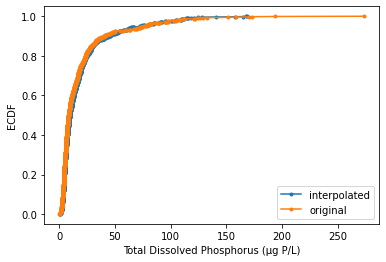

In [13]:
comp_ecdf(interpolated_features, sites_df, 'Total Dissolved Phosphorus (µg P/L)', 
          name1='interpolated', name2='original')

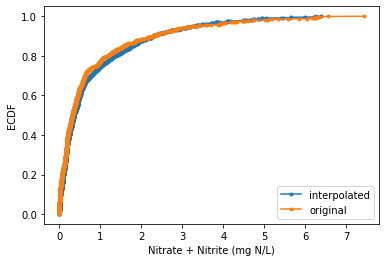

In [14]:
comp_ecdf(interpolated_features, sites_df, 'Nitrate + Nitrite (mg N/L)', 
          name1='interpolated', name2='original')

The interpolated and original distributions are quite similar. Let's examine how the linear interpolation and time-shifted data looks for one site, WE2.

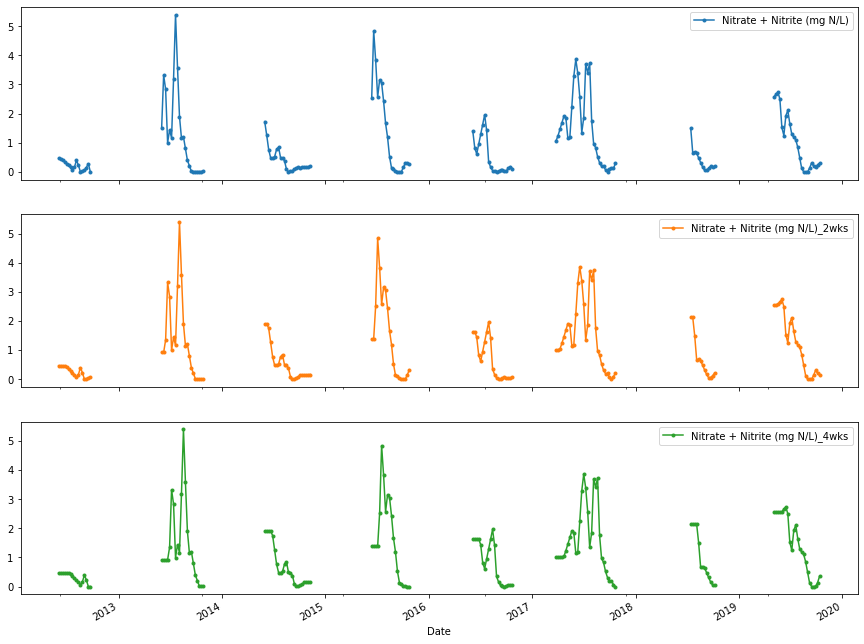

In [15]:
we2 = interpolated_features[interpolated_features.Site == 'WE2']
timeplot(we2.reset_index(), ['Nitrate + Nitrite (mg N/L)','Nitrate + Nitrite (mg N/L)_2wks','Nitrate + Nitrite (mg N/L)_4wks'], logy=False)


The linear interpolation preserves the general features of the data, and we can see the time shift as expected.

## Selecting Past Features

Our goal is to be able to forecast microcystin concentrations based on past nutrient concentrations and environmental data. Therefore we moved on to training models using only features that are obtainable two weeks prior to the desired prediction date. We will also remove the site labels to see if we could make reasonable predictions based only on site distance from shore and from the Maumee River inlet.

In [16]:
past_features = ['Month', 'Distance from Maumee Inlet (km)', 'Shore Distance (euc dis)',
             'CTD Temperature (°C)_2wks','CTD Temperature (°C)_4wks', 'CTD Temperature (°C)_6wks',
             'CTD Dissolved Oxygen (mg/L)_2wks', 'CTD Dissolved Oxygen (mg/L)_4wks', 'CTD Dissolved Oxygen (mg/L)_6wks',
             'Total Phosphorus (µg P/L)_2wks', 'Total Phosphorus (µg P/L)_4wks','Total Phosphorus (µg P/L)_6wks',
             'Total Dissolved Phosphorus (µg P/L)_2wks','Total Dissolved Phosphorus (µg P/L)_4wks','Total Dissolved Phosphorus (µg P/L)_6wks',
             'Soluble Reactive Phosphorus (µg P/L)_2wks', 'Soluble Reactive Phosphorus (µg P/L)_4wks', 'Soluble Reactive Phosphorus (µg P/L)_6wks',
             'Ammonia (µg N/L)_2wks', 'Ammonia (µg N/L)_4wks','Ammonia (µg N/L)_6wks',
             'Nitrate + Nitrite (mg N/L)_2wks', 'Nitrate + Nitrite (mg N/L)_4wks','Nitrate + Nitrite (mg N/L)_6wks', 
             'N:P Mass Ratio_2wks', 'N:P Mass Ratio_4wks', 'N:P Mass Ratio_6wks']

X_df = interpolated_features[past_features]
y_df = interpolated_features['Particulate Microcystin (µg/L)']

## Scaling and Power Transformations

Let's take another look at the feature distributions before scaling. For an in-depth discussion of feature distributions see the data wrangling and EDA notebooks.

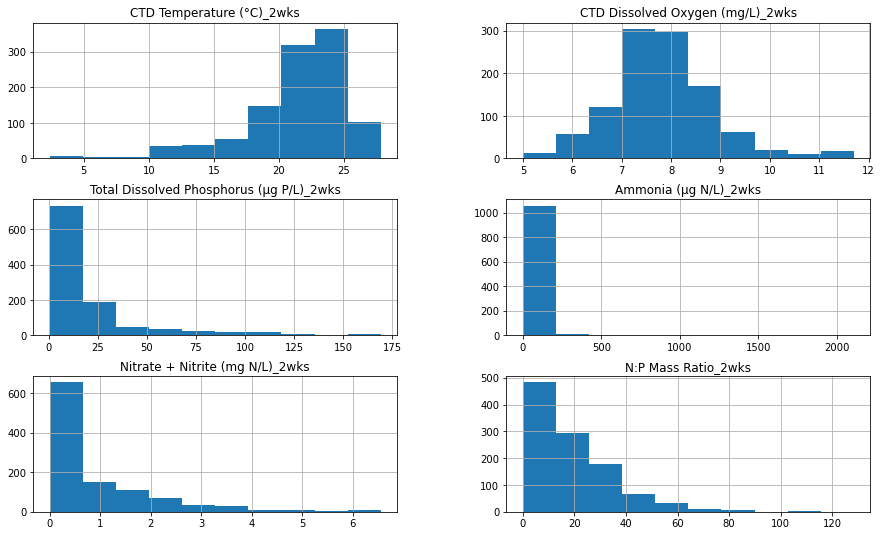

In [17]:
cols = ['CTD Temperature (°C)_2wks', 'CTD Dissolved Oxygen (mg/L)_2wks',
       'Total Dissolved Phosphorus (µg P/L)_2wks','Ammonia (µg N/L)_2wks', 
        'Nitrate + Nitrite (mg N/L)_2wks', 'N:P Mass Ratio_2wks']

X_df[cols].hist(figsize=(15,9))
plt.show()

The chemical features have highly skewed distributions. They will be log transformed to increase the normality of their distributions before they are standardized. The temperature and dissolved oxygen distributions are more similar to already being normally distributed but for convenience will also be log transformed and standardized. Before doing that the data must be split into training and testing sets. Because this is time series data we will not shuffle the training and testing set. If we did so then in some instances the model would be training on points that occur after or around the same time as points in the testing set.

In [18]:
X = X_df.values
y = y_df.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(858, 27)
(215, 27)
(858,)
(215,)


In [19]:
X_train_df = pd.DataFrame(X_train, columns=X_df.columns)
X_test_df = pd.DataFrame(X_train, columns=X_df.columns)

X_train_df.head()

,Month,Distance from Maumee Inlet (km),Shore Distance (euc dis),CTD Temperature (°C)_2wks,CTD Temperature (°C)_4wks,CTD Temperature (°C)_6wks,CTD Dissolved Oxygen (mg/L)_2wks,CTD Dissolved Oxygen (mg/L)_4wks,CTD Dissolved Oxygen (mg/L)_6wks,Total Phosphorus (µg P/L)_2wks,...,Soluble Reactive Phosphorus (µg P/L)_6wks,Ammonia (µg N/L)_2wks,Ammonia (µg N/L)_4wks,Ammonia (µg N/L)_6wks,Nitrate + Nitrite (mg N/L)_2wks,Nitrate + Nitrite (mg N/L)_4wks,Nitrate + Nitrite (mg N/L)_6wks,N:P Mass Ratio_2wks,N:P Mass Ratio_4wks,N:P Mass Ratio_6wks
0,6,13.5722,0.0552312,22.5,22.5,22.25,7.68571,7.7,7.78304,42.01,...,5.15,14.68,14.68,14.68,0.466,0.466,0.466,11.0926,11.0926,11.0926
1,6,13.5608,0.0553021,22.5,22.5,22.25,7.68571,7.7,7.78304,42.01,...,5.15,14.68,14.68,14.68,0.466,0.466,0.466,11.0926,11.0926,11.0926
2,6,13.5436,0.0554894,22.5,22.5,22.25,7.68571,7.7,7.78304,41.1965,...,5.15,14.6192,14.68,14.68,0.464831,0.466,0.466,11.3414,11.0926,11.0926
3,6,13.524,0.055773,22.5,22.5,22.25,7.68571,7.7,7.78304,35.3664,...,5.15,14.1836,14.68,14.68,0.456455,0.466,0.466,13.1246,11.0926,11.0926
4,7,13.5194,0.0556596,22.5,22.5,22.25,7.68571,7.7,7.78304,29.2627,...,5.15,16.5018,14.6192,14.68,0.419909,0.464831,0.466,14.3666,11.3414,11.0926


In [20]:
y_train.shape

(858,)

In [21]:
#select skewed features for X and y train and test sets
skewed_Xtrain = pd.DataFrame(X_train, columns=X_df.columns).drop(columns=['Month'])
skewed_Xtest = pd.DataFrame(X_test, columns=X_df.columns).drop(columns=['Month'])

skewed_ytrain = pd.DataFrame({'Particulate Microcystin (µg/L)': y_train})
skewed_ytest = pd.DataFrame({'Particulate Microcystin (µg/L)': y_test})

In [22]:
#fit and transform skewed features with power transformer
logX = PowerTransformer()
logX.fit(skewed_Xtrain)
logfit_Xtrain = logX.transform(skewed_Xtrain)
logfit_Xtest = logX.transform(skewed_Xtest)

logY = PowerTransformer()
logY.fit(skewed_ytrain)
logfit_ytrain = logY.transform(skewed_ytrain)
logfit_ytest = logY.transform(skewed_ytest)

In [23]:
#save the logY object for inverse transformation after modeling
pickle.dump(logY, file=open('../models/logY.pickle', 'wb'))

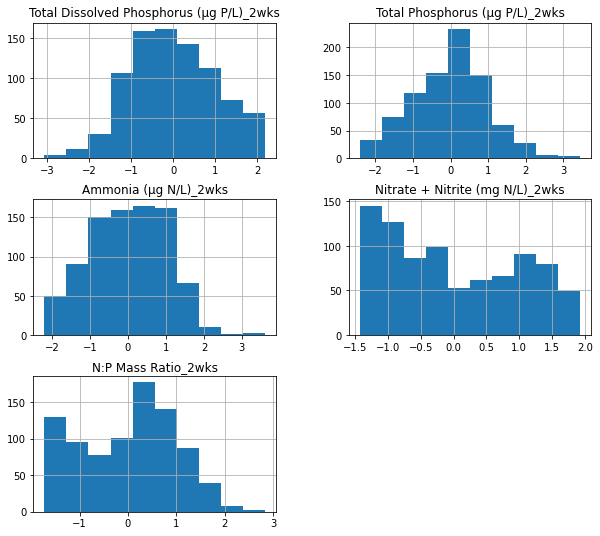

In [24]:
#rename transformed features with appropriate column labels
scaled_Xtrain = pd.DataFrame(logfit_Xtrain, columns=skewed_Xtrain.columns)
scaled_Xtest = pd.DataFrame(logfit_Xtest, columns=skewed_Xtrain.columns)
scaled_Xtrain['Month'] = X_train_df['Month']
scaled_Xtest['Month'] = X_test_df['Month']
scaled_ytrain = pd.DataFrame({'Particulate Microcystin (µg/L)': logfit_ytrain.flatten()})
scaled_ytest = pd.DataFrame({'Particulate Microcystin (µg/L)': logfit_ytest.flatten()})

scaled_Xtrain[['Total Dissolved Phosphorus (µg P/L)_2wks',
         'Total Phosphorus (µg P/L)_2wks',
         'Ammonia (µg N/L)_2wks', 
         'Nitrate + Nitrite (mg N/L)_2wks', 
         'N:P Mass Ratio_2wks']].hist(figsize=(10,9))
plt.show()

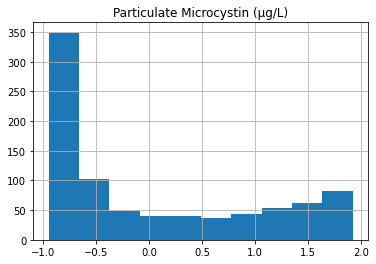

In [25]:
scaled_ytrain.hist()
plt.show()

## Principle Component Analysis

Let's explore if linear combinations of our features can capture the variance of the data using fewer dimensions. While we may not intend to use PCA to generate new features used for machine learning this perhaps still give some insight into the data. 

In [26]:
scaled_Xtrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 27 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Distance from Maumee Inlet (km)            858 non-null    float64
 1   Shore Distance (euc dis)                   858 non-null    float64
 2   CTD Temperature (°C)_2wks                  858 non-null    float64
 3   CTD Temperature (°C)_4wks                  858 non-null    float64
 4   CTD Temperature (°C)_6wks                  858 non-null    float64
 5   CTD Dissolved Oxygen (mg/L)_2wks           858 non-null    float64
 6   CTD Dissolved Oxygen (mg/L)_4wks           858 non-null    float64
 7   CTD Dissolved Oxygen (mg/L)_6wks           858 non-null    float64
 8   Total Phosphorus (µg P/L)_2wks             858 non-null    float64
 9   Total Phosphorus (µg P/L)_4wks             858 non-null    float64
 10  Total Phosphorus (µg P/L)_

In [27]:
scaled_Xtrain['Month'].unique()

array([6, 7, 8, 9, 10, 11, 3, 4, 5], dtype=object)

In [28]:
#select X features
Xs = scaled_Xtrain.values
Xs.shape

(858, 27)

In [29]:
#initialize and fit PCA object
pca = PCA()
pca.fit(Xs)

PCA()

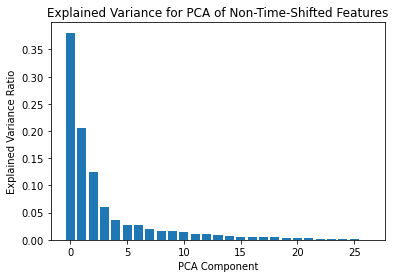

In [30]:
#plot explained variance for each component
plt.bar(list(range(27)), pca.explained_variance_ratio_)
plt.xlabel('PCA Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance for PCA of Non-Time-Shifted Features')
plt.show()

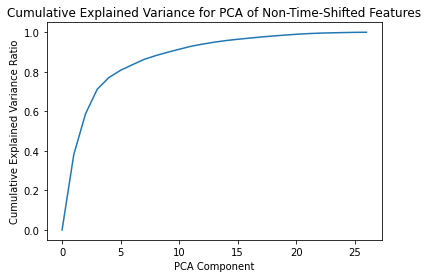

In [31]:
plt.plot(list(range(27)), [sum(pca.explained_variance_ratio_[:i]) for i in range(27)])
plt.xlabel('PCA Component')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance for PCA of Non-Time-Shifted Features')
plt.show()

The first five components seem to explain about 80% of the variance in the data, and the first three components seem to account for 60% of the variance in the data.

In [32]:
#select first and second PCA coordinates for each feature point
x0 = pca.fit_transform(Xs)[:,0]
x1 = pca.fit_transform(Xs)[:,1]
x2 = pca.fit_transform(Xs)[:,2]

Let's plot the data with the PCA components as our basis vectors and scaled particulate microcystin level as the hue.

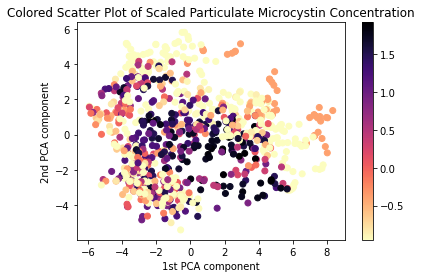

In [33]:
plt.scatter(x0, x1, c=scaled_ytrain['Particulate Microcystin (µg/L)'], cmap='magma_r')
plt.xlabel('1st PCA component')
plt.ylabel('2nd PCA component')
plt.title('Colored Scatter Plot of Scaled Particulate Microcystin Concentration')
plt.colorbar()
plt.show()

There doesn't seem to be much meaningful separation of the microcystin levels with just two pca components, but we can also plot in three dimensions.

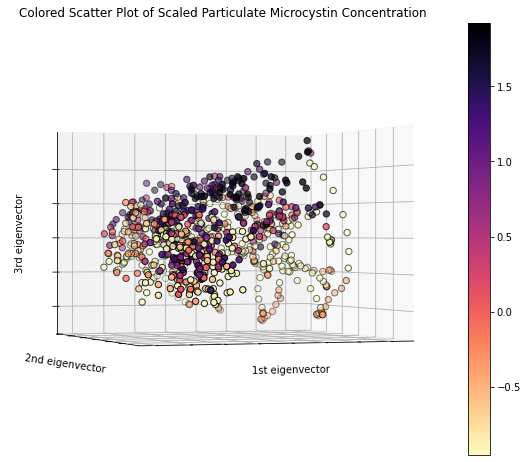

In [34]:
#generate 3D scatterplot of first three PCA components - take every 3rd data point to see plot more clearly.
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=0, azim=-110)
p = ax.scatter(x0, x1, x2, c=scaled_ytrain['Particulate Microcystin (µg/L)'],
           cmap='magma_r', edgecolor='k', s=40)
plt.colorbar(p)
ax.set_title("Colored Scatter Plot of Scaled Particulate Microcystin Concentration")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])
plt.show()

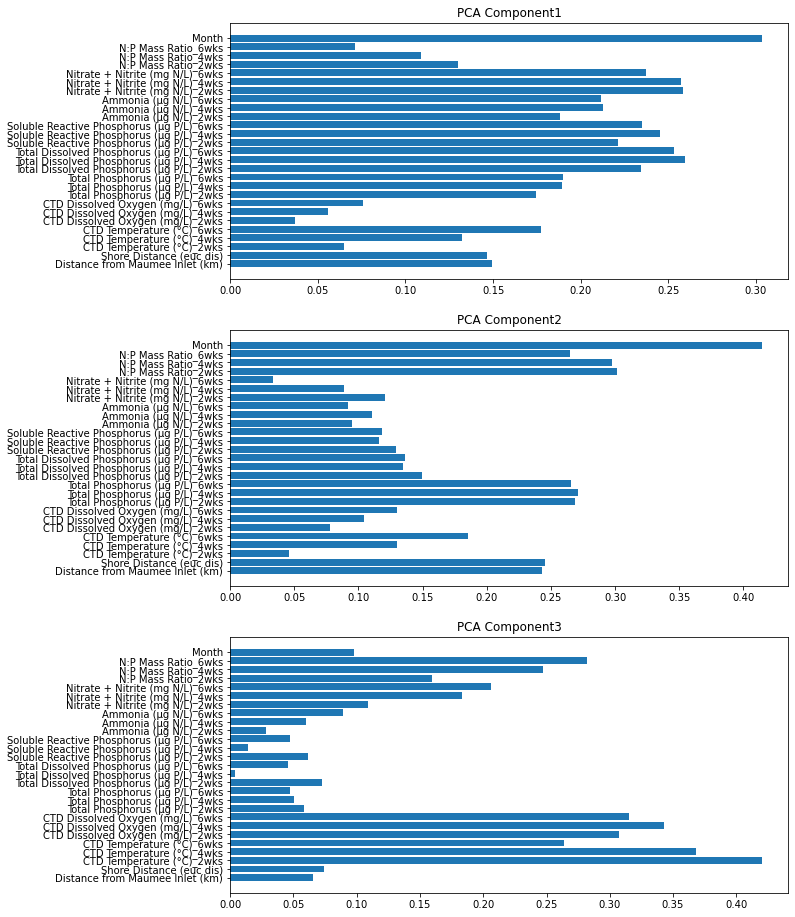

In [35]:
#plot the feature contributions to each pca component
fig, ax = plt.subplots(3, figsize=(10, 16))
for i in range(3):
    ax[i].barh(y=scaled_Xtrain.columns, width=np.abs(pca.components_[i]))
    ax[i].set_title('PCA Component' + str(i+1))
plt.show()

The first PCA component is mainly comprised of month and nutrient features. The second PCA component is more heavily composed phosphorus-containing nutrients, N:P mass ratio, and month. The third PCA component is comprised mainly of dissolved oxygen and temperature information. 

## Save Train and Testing Sets

In [36]:
scaled_Xtrain.to_csv('../data/processed/resampled_Xtrain.csv')
scaled_Xtest.to_csv('../data/processed/resampled_Xtest.csv')
scaled_ytrain.to_csv('../data/processed/resampled_ytrain.csv')
scaled_ytest.to_csv('../data/processed/resampled_ytest.csv')

In [37]:
unscaled = pd.concat([pd.get_dummies(interpolated_features[['Month']]).drop(columns=['Month_11']), 
                      interpolated_features[past_features + ['Particulate Microcystin (µg/L)']]], axis=1).drop(columns=['Month'])
unscaled.to_csv('../data/processed/resampled_unscaled.csv')

In [38]:
unscaled.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1073 entries, 2012-06-03 to 2019-10-13
Data columns (total 35 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Month_3                                    1073 non-null   uint8  
 1   Month_4                                    1073 non-null   uint8  
 2   Month_5                                    1073 non-null   uint8  
 3   Month_6                                    1073 non-null   uint8  
 4   Month_7                                    1073 non-null   uint8  
 5   Month_8                                    1073 non-null   uint8  
 6   Month_9                                    1073 non-null   uint8  
 7   Month_10                                   1073 non-null   uint8  
 8   Distance from Maumee Inlet (km)            1073 non-null   float64
 9   Shore Distance (euc dis)                   1073 non-null   float64
 10  CTD Te